# F20AA Applied Text Analytics: Coursework 2

In [1]:
# %pip install nltk
# %pip install pandarallel

In [3]:
import pickle
import bz2

import matplotlib.pyplot as plt
import pandas as pd

# preprocessing
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag, pos_tag_sents
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import sklearn.metrics
from sklearn.model_selection import train_test_split

# optimization
from pandarallel import pandarallel
pandarallel.initialize()
# Imports

# for representation/classification
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
import gensim
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\alora\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alora\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\alora\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alora\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


# 1. Data Exploration and Visualization

In [47]:
# saving data in a pickle file
""" Train.csv exceeds file size limit on GitHub """

# data = pd.read_csv("Train.csv")
# with bz2.BZ2File("train.pickle", "wb") as f:
#     pickle.dump(data, f)
#     f.close()

' Train.csv exceeds file size limit on GitHub '

In [48]:
# loading data from pickle
with bz2.BZ2File("train.pickle", "rb") as f:
    train = pickle.load(f)
    f.close()

In [49]:
train.head()

,overall,Review
0,5,This a really cool (but time-tested) design. T...
1,5,I liked the first pair so well I bought severa...
2,4,I took them to the range to put them to the te...
3,5,What can you say about a yoga block? These ar...
4,5,After reading many reviews I decided on this l...


In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222243 entries, 0 to 222242
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   overall  222243 non-null  int64 
 1   Review   222243 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In [51]:
train.describe()

,overall
count,222243.000000
mean,4.394771
std,0.985039
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


These tables give us the initial information we need about the dataset - it has two columns, 'overall' which is like a likert scale between 1-5 and is to be used for multiclass classification, and 'Review' which adds onto 'overall' and is a brief subjective opinion of the reviewer on the product. There are only two columns and no missing values, therefore no direct modification needs to be done to the dataset other than preprocessing.

**For explanation purposes, 1-2 will be assumed as negative, 3 as neutral, and 4-5 as positive reviews.**

### Distribution of data

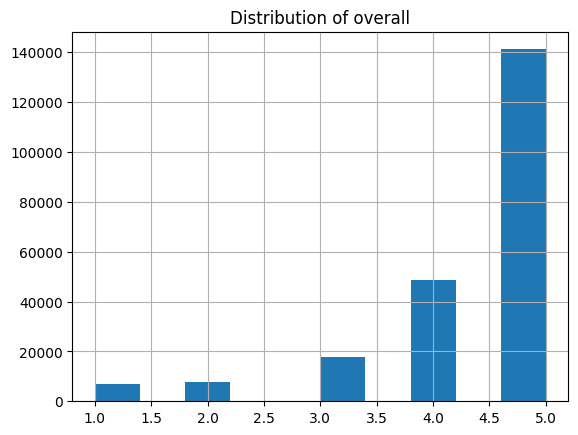

In [52]:
# distribution of overall
train.hist()
plt.title("Distribution of overall")
plt.show()

In [53]:
train['overall'].value_counts()

5    141169
4     48748
3     17947
2      7650
1      6729
Name: overall, dtype: int64

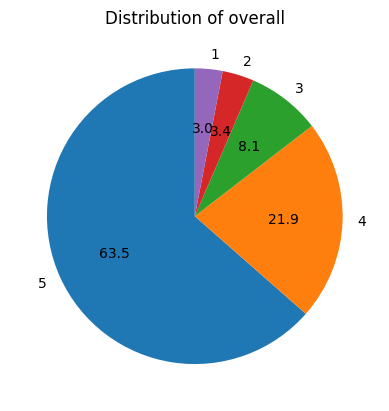

In [54]:
count = train['overall'].value_counts()
plt.pie(count, labels=count.index, autopct="%1.1f", startangle=90)
plt.title("Distribution of overall")
plt.show()

The graphs show that this dataset is extremely unbalanced, with most of the data (~85%) in "classes" 4 and 5. This can prove challenging for our future text classifier, especially for a multi-classification task, as the model may be biased towards the class with the most data and will result to overfitting and inaccurate classification.

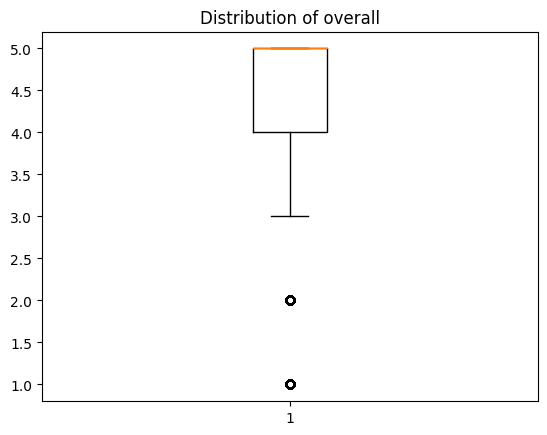

In [55]:
plt.boxplot(train['overall'])
plt.title("Distribution of overall")
plt.show()

A box plot is extremely helpful as it can help us detect any outliers. Here, the plot has marked the minimum and maximum values as 3 and 5 respectively, with most of the data concentrated in classes 4 and 5. As expected, 5 has also been marked as the median as it is the class with the most data. Classes 1 and 2 have been considered as outliers. In most cases, outliers can and should be removed to make sure the classification process can run smoothly and avoid any miss classifications. But, as classes 1 and 2 are the only "negative" classes in this dataset, these outliers cannot be removed, otherwise the data and classifier will render useless.

### Text data

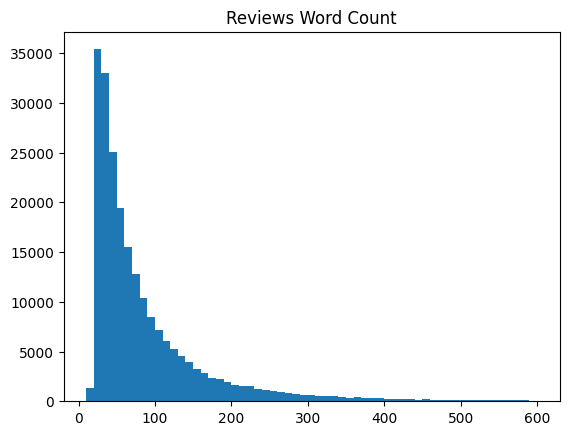

In [56]:
# checking word count
train['Word Count'] = [len(i.split()) for i in list(train['Review'])]

plt.hist(train['Word Count'], bins = range(10, 601, 10))
plt.title("Reviews Word Count")
plt.show()

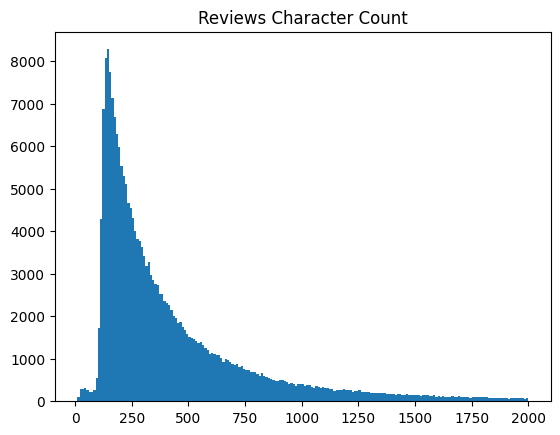

In [57]:
# checking character count
train['Character Count'] = [len(i) for i in list(train['Review'])]

plt.hist(train['Character Count'], bins = range(10, 2001, 10))
plt.title("Reviews Character Count")
plt.show()

Most reviews seem to be short - approx. under 100 words and 500 characters.

### Checking for correlation

In [58]:
train.corr(numeric_only=True)

,overall,Word Count,Character Count
overall,1.000000,-0.072247,-0.069287
Word Count,-0.072247,1.000000,0.997638
Character Count,-0.069287,0.997638,1.000000


Sadly, word and character count seem to have no correlation with the overall scale, therefore these counts will not provide help with classification.

# 2. Text Processing and Normalization

### Making it lowercase

In [59]:
train['Cleaned Reviews'] = train['Review'].parallel_apply(lambda x: " ".join(x.lower() for x in x.split()))

### Removing punctuation and numbers

In [60]:
train['Cleaned Reviews'] = train['Cleaned Reviews'].str.replace('[^\w\s]|[0-9]+','', regex=True)

In [61]:
train['Cleaned Reviews'].head()

0    this a really cool but timetested design the c...
1    i liked the first pair so well i bought severa...
2    i took them to the range to put them to the te...
3    what can you say about a yoga block these are ...
4    after reading many reviews i decided on this l...
Name: Cleaned Reviews, dtype: object

### Removing stopwords

In [62]:
stopw = set(stopwords.words('english'))

In [63]:

train['Cleaned Reviews'] = train['Cleaned Reviews'].apply(lambda rev: " ".join([str for str in rev.split(' ') if str not in stopw]) )

In [64]:
train['Cleaned Reviews'].head()

0    really cool timetested design carbon steel bla...
1    liked first pair well bought several found usu...
2    took range put test adjust volume hear people ...
3    say yoga block solid sturdy  namebrand feared ...
4    reading many reviews decided light satisfied d...
Name: Cleaned Reviews, dtype: object

### Splitting into tokens

Tokenizing is the method of splitting up a corpus into 'tokens' - usually achieved by spltting the text into individual components.

In [65]:
train['Tokenized Reviews'] = train['Cleaned Reviews'].parallel_apply(word_tokenize)

In [66]:
train['Tokenized Reviews'].head()

0    [really, cool, timetested, design, carbon, ste...
1    [liked, first, pair, well, bought, several, fo...
2    [took, range, put, test, adjust, volume, hear,...
3    [say, yoga, block, solid, sturdy, namebrand, f...
4    [reading, many, reviews, decided, light, satis...
Name: Tokenized Reviews, dtype: object

The next step is to lemmatize the tokens, however...

In [67]:
wnl = WordNetLemmatizer()
print(wnl.lemmatize('liked'))

liked


By default, NLTK's WordNetLemmatizer assumes every word is a noun and will lemmatize text incorrectly if POS-tagging (Parts-Of-Speech Tagging) is not done beforehand.

Source: https://www.nltk.org/api/nltk.stem.wordnet.html?highlight=lemmatiz#nltk.stem.wordnet.WordNetLemmatizer.lemmatize

In [68]:
train['Tagged Reviews'] = train['Tokenized Reviews'].parallel_apply(pos_tag)

However, the POS-tag given by NLTK's POS tagger is not an accepted format for NLTK's WordNetLemmatizer, so it needs to be mapped.

In [69]:
# From https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python/15590384#15590384

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
def wordnet_format(text):
    return [(word[0],get_wordnet_pos(word[1])) for word in text]


train['Tagged Reviews'] = train['Tagged Reviews'].apply(wordnet_format)

In [70]:
example1 = train['Tokenized Reviews'].iloc[1].copy()
example1pos = train['Tagged Reviews'].iloc[1].copy()

print("Without POS-tag:")
print([wnl.lemmatize(word) for word in example1[:5]])
print("With POS-tag: ")
print([wnl.lemmatize(word[0], pos=word[1]) for word in example1pos[:5]])

Without POS-tag:
['liked', 'first', 'pair', 'well', 'bought']
With POS-tag: 
['like', 'first', 'pair', 'well', 'buy']


As shown above, without POS-tagging, NLTK's lemmatizer doesn't correctly lemmatize verbs. Now that the text has been tokenized and POS-tagged, it can be lemmatized.

### Lemmatizing the tokens

Lemmatization is a text normalization technique used throughout NLP models. Oftentimes, it is the preferred normalization method over stemming, shown by SpaCy opting to drop stemming from its library entirely. 

In [71]:
train['Lemmatized Reviews'] = train['Tagged Reviews'].apply(lambda x: [wnl.lemmatize(word[0], pos=word[1]) if word[1] is not None else wnl.lemmatize(word[0]) for word in x ])
train['Lemmatized Reviews'].head()

0    [really, cool, timetested, design, carbon, ste...
1    [like, first, pair, well, buy, several, find, ...
2    [take, range, put, test, adjust, volume, hear,...
3    [say, yoga, block, solid, sturdy, namebrand, f...
4    [read, many, review, decide, light, satisfied,...
Name: Lemmatized Reviews, dtype: object

### Stemming the tokens

In [72]:
stem = PorterStemmer()
train['Stemmed Reviews'] = train['Tokenized Reviews'].apply(
    lambda rev: [stem.stem(text) for text in rev])
train['Stemmed Reviews'].head()

0    [realli, cool, timetest, design, carbon, steel...
1    [like, first, pair, well, bought, sever, found...
2    [took, rang, put, test, adjust, volum, hear, p...
3    [say, yoga, block, solid, sturdi, namebrand, f...
4    [read, mani, review, decid, light, satisfi, da...
Name: Stemmed Reviews, dtype: object

In [73]:
train.to_pickle('preproc.pkl')

### Evaluating Stemming vs Lemmatization

To evaluate which would perform better, stemming and lemmatization will be compared on their performance on a variety of text representation using a baseline classifier, logistic regression.

### Stemming

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
strings_Stemmed = train["Stemmed Reviews"].map(' '.join)

# Using Bag of Words, we represent the stemmed strings
bow_converter = CountVectorizer(tokenizer=lambda doc: doc)
x_bow = bow_converter.fit_transform(strings_Stemmed)


c:\Users\alora\anaconda3\envs\aa\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
# Using ngrams 
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc,
ngram_range=(2,2))
x_bigram = bigram_converter.fit_transform(strings_Stemmed)
trigram_converter = CountVectorizer(tokenizer=lambda doc: doc,
ngram_range=(3,3))
x_trigram = trigram_converter.fit_transform(strings_Stemmed)


KeyboardInterrupt: 

In [ ]:
#Using tf-idf
tfidf_vectorizer = TfidfVectorizer()
doc_vec = tfidf_vectorizer.fit_transform(strings_Stemmed)

In [ ]:
from sklearn.linear_model import LogisticRegression
Y = train['overall']

def simple_logistic_classify(X_tr, y_tr, X_test, y_test, description, _C=1.0):
    model = LogisticRegression(C=_C).fit(X_tr, y_tr)
    score = model.score(X_test, y_test)
    print('Test Score with', description, 'features', score)
    return model

def splitclassify(x, type):
    train_X, test_X, train_y, test_y = train_test_split(x, Y, random_state=50)
    simple_logistic_classify(train_X, train_y, test_X, test_y, type)

In [ ]:
splitclassify(x_bow, "BOW")
splitclassify(x_bigram, "bigram")
splitclassify(x_trigram, "trigram")
splitclassify(doc_vec, "tfidf")


c:\Users\alora\anaconda3\envs\aa\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Score with BOW features 0.6331959467972139


c:\Users\alora\anaconda3\envs\aa\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Score with bigram features 0.6479365022227822


c:\Users\alora\anaconda3\envs\aa\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Score with trigram features 0.6834650204279981
Test Score with tfidf features 0.6963157610554166


c:\Users\alora\anaconda3\envs\aa\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### Lemmatizing

In [ ]:
strings_lemma = train["Lemmatized Reviews"].map(' '.join)

# Using Bag of Words, we represent the stemmed strings
bow_converter = CountVectorizer(tokenizer=lambda doc: doc)
x_bow = bow_converter.fit_transform(strings_lemma)

In [ ]:
# Using ngrams 
bigram_converter = CountVectorizer(tokenizer=lambda doc: doc,
ngram_range=(2,2))
x_bigram = bigram_converter.fit_transform(strings_lemma)
trigram_converter = CountVectorizer(tokenizer=lambda doc: doc,
ngram_range=(3,3))
x_trigram = trigram_converter.fit_transform(strings_lemma)

In [ ]:
#Using tf-idf
tfidf_vectorizer = TfidfVectorizer()
doc_vec = tfidf_vectorizer.fit_transform(strings_lemma)

In [ ]:
splitclassify(x_bow, "BOW")
splitclassify(x_bigram, "bigram")
splitclassify(x_trigram, "trigram")
splitclassify(doc_vec, "tfidf")

c:\Users\alora\anaconda3\envs\aa\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Score with BOW features 0.6322420402800526


c:\Users\alora\anaconda3\envs\aa\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Score with bigram features 0.6465686362736451


c:\Users\alora\anaconda3\envs\aa\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Score with trigram features 0.6828170839257752


c:\Users\alora\anaconda3\envs\aa\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Score with tfidf features 0.6929500908910927


### Results

| Text Representation | Stemming Score | Lemmatizing Score |
|---------------------|----------------|-------------------|
| BOW | 0.6332 |0.6322|
|Bigrams |0.6479|0.6466|
|Trigrams|0.6835|0.6828|
|Tf-idf|0.6963|0.6930|

Though the performance is very similar, it can be observed that stemming outperforms lemmatization by 0.0015 on average. This difference is negligible however, and it can be concluded that the normalization technique does not vary performance as much as the text representation technique and classification technique does. 

# 3. & 4. Grid Search over Text Vectorization Techniques and Classifiers

In [ ]:
# Load the training data
with open('preproc.pkl', 'rb') as f:
    train = pickle.load(f)

In [ ]:
train = train[['Lemmatized Reviews', 'overall']]

In [ ]:
X = train['Lemmatized Reviews']
y = train.overall

Preparing the search space of each of the parameters

In [ ]:

text_reps = {
    'bow': CountVectorizer(
        preprocessor= lambda x: x, # override preprocessor
        tokenizer= lambda x: x  # override tokenization
    ),
    'tfidf': TfidfVectorizer(
        preprocessor= lambda x: x, # override preprocessor
        tokenizer= lambda x: x  # override tokenization
    ),
}

classifiers = {
    'sgd': SGDClassifier() # the 3 classifiers are defined by the loss hyperparameter
}

params = {
    # bag of ngrams
    'bow':{
        'countvectorizer__ngram_range': [(a, a) for a in np.arange(1, 5)],
    },
    # tdfidf ngrams
    'tfidf': {
        'tfidfvectorizer__ngram_range':[(a, a) for a in np.arange(1, 5)],
    },
    # classifiers
    'sgd': {
        "sgdclassifier__loss": ["perceptron", "hinge", "log_loss"], # hinge is SVM, log_loss is logistic Reg, perceptron is perceptron
        "sgdclassifier__alpha": [0.0001,0.001,0.01,0.1],
        "sgdclassifier__penalty": ["l2"],
    }
}




In [ ]:
params

Time taken for grid search of bag of TFIDF with all classifiers:
- CPU times: 
    - user 2h 38min 29s, 
    - sys: 29min 18s, 
    - total: 3h 7min 48s
- Wall time: 2h 40min 28s

Time for grid search of bag of N-grams with all classifiers:
- CPU times: 
    - user 2h 30min 27s, 
    - sys: 25min 34s, 
    - total: 2h 56min 2s
- Wall time: 2h 28min 41s

In [ ]:
%%time
text_reps = {
    'tfidf': TfidfVectorizer(
        preprocessor=lambda x: x,  # override preprocessor
        tokenizer=lambda x: x  # override tokenization
    ),
}

scores_tfidf_penalty_l2_all_classifiers = []

for text_rep, text_rep_obj in text_reps.items():
    for classifier, classifier_obj  in classifiers.items():
        print(classifier, text_rep)
        pipe = make_pipeline(text_rep_obj, classifier_obj)
        print(pipe)
        grid_search = GridSearchCV(estimator=pipe, param_grid={**params[text_rep], **params[classifier]}, cv=5, scoring=['accuracy', 'f1_weighted'], refit="accuracy")
        grid_search.fit(X, y)
        scores_tfidf_penalty_l2_all_classifiers.append({
            'model': classifier,
            'text_representation': text_rep,
            'scores': grid_search.cv_results_
        })

In [ ]:
%%time
text_reps = {
    'bow': CountVectorizer(
        preprocessor= lambda x: x, # override preprocessor
        tokenizer= lambda x: x  # override tokenization
    ),
}

scores_bow_penalty_l2_all_classifiers = []

for text_rep, text_rep_obj in text_reps.items():
    for classifier, classifier_obj  in classifiers.items():
        print(classifier, text_rep)
        pipe = make_pipeline(text_rep_obj, classifier_obj)
        print(pipe)
        grid_search = GridSearchCV(estimator=pipe, param_grid={**params[text_rep], **params[classifier]}, cv=5, scoring=['accuracy', 'f1_weighted'], refit="accuracy")
        grid_search.fit(X, y)
        scores_bow_penalty_l2_all_classifiers.append({
            'model': classifier,
            'text_representation': text_rep,
            'scores': grid_search.cv_results_
        })

## Results
The results have been saved to 'results/results_new.pkl' file.

In [5]:
with open('results/results_new.pkl', 'rb') as f:
    results_new = pickle.load(f)

In [6]:
results_new

,Text_Rep,SGD_Loss,SGD_Alpha,SGD_Penalty,Mean_Accuracy,Mean_F1
0,"Bag of N-grams range (1, 1)",perceptron,0.0001,l2,0.626431,0.612261
1,"Bag of N-grams range (1, 1)",hinge,0.0001,l2,0.685110,0.632835
2,"Bag of N-grams range (1, 1)",log_loss,0.0001,l2,0.689579,0.642532
3,"Bag of N-grams range (1, 1)",perceptron,0.0010,l2,0.629770,0.614124
4,"Bag of N-grams range (1, 1)",hinge,0.0010,l2,0.677794,0.603539
...,...,...,...,...,...,...
91,"Bag of TFIDF N-grams range (4, 4)",hinge,0.1000,l2,0.635201,0.493493
92,"Bag of TFIDF N-grams range (1, 1)",log_loss,0.1000,l2,0.635201,0.493493
93,"Bag of TFIDF N-grams range (2, 2)",log_loss,0.1000,l2,0.635201,0.493493
94,"Bag of TFIDF N-grams range (3, 3)",log_loss,0.1000,l2,0.635201,0.493493


Sorting by accuracy and F1 score

In [7]:
results_new.sort_values(by=['Mean_Accuracy', 'Mean_F1'],ascending=False)

,Text_Rep,SGD_Loss,SGD_Alpha,SGD_Penalty,Mean_Accuracy,Mean_F1
2,"Bag of N-grams range (1, 1)",log_loss,0.0001,l2,0.689579,0.642532
1,"Bag of N-grams range (1, 1)",hinge,0.0001,l2,0.685110,0.632835
5,"Bag of N-grams range (1, 1)",log_loss,0.0010,l2,0.684382,0.623374
13,"Bag of N-grams range (2, 2)",hinge,0.0001,l2,0.680498,0.630539
4,"Bag of N-grams range (1, 1)",hinge,0.0010,l2,0.677794,0.603539
...,...,...,...,...,...,...
75,"Bag of TFIDF N-grams range (4, 4)",perceptron,0.0100,l2,0.588675,0.533826
74,"Bag of TFIDF N-grams range (3, 3)",perceptron,0.0100,l2,0.586421,0.573769
86,"Bag of TFIDF N-grams range (3, 3)",perceptron,0.1000,l2,0.586259,0.573480
50,"Bag of TFIDF N-grams range (3, 3)",perceptron,0.0001,l2,0.586012,0.573478


# 5. Sequence Modelling

In [40]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from keras.models import Sequential, Model

import gensim

In [2]:
preprocessed_data = pd.read_pickle('preproc.pkl')
X, y = preprocessed_data['Lemmatized Reviews'], preprocessed_data['overall']

X.head()

0    [really, cool, timetested, design, carbon, ste...
1    [like, first, pair, well, buy, several, find, ...
2    [take, range, put, test, adjust, volume, hear,...
3    [say, yoga, block, solid, sturdy, namebrand, f...
4    [read, many, review, decide, light, satisfied,...
Name: Lemmatized Reviews, dtype: object

In [3]:
# preprocessing for lstm
def sequencing(X):
    # fitting text to create a vocabulary
    vocab_size = 5000
    embedding_size = 100
    
    tokenizer = Tokenizer(num_words=vocab_size)
    tokenizer.fit_on_texts(X)
    #convert data to numerical
    X = tokenizer.texts_to_sequences(X)

    return X, vocab_size, embedding_size

In [4]:
# code from: https://stackoverflow.com/questions/42064690/using-pre-trained-word2vec-with-lstm-for-word-generation
def embeddings_preprocess(X):

    word_model = gensim.models.Word2Vec(X, vector_size=100, min_count=1, window=5, max_vocab_size=5000)
    weights = word_model.wv.vectors
    vocab_size, embedding_size = weights.shape

    # changing text to numerical
    X = np.asarray(X)
    copy = np.copy(X)
    for i, sentence in enumerate(copy):
        for t, word in enumerate(sentence):
            if word in word_model.wv:
                X[i][t] = word_model.wv.key_to_index[word]
            else:
                X[i][t] = 0.0

    return X, vocab_size, embedding_size, weights

In [5]:
X1, vocab_size1, embedding_size1 = sequencing(X)
X2, vocab_size2, embedding_size2, weights = embeddings_preprocess(X)

In [6]:
max_len = 100

def sequence_preprocess(X, y):
    # padding the reviews so they are the same length
    # setting max length as 100 as in part 1 (data exploration), most reviews are under 100 words
    X = sequence.pad_sequences(X, maxlen = max_len, dtype = 'object')
    # splitting train and test 1:1 ratio
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)
    # changing data to fit classifier 
    X_train = np.asarray(X_train).astype(np.int32)
    X_test = np.asarray(X_test).astype(np.int32)

    # one hot encoding classification labels
    enc = OneHotEncoder()
    encoded = enc.fit_transform(np.asarray(y_train).reshape(-1, 1))
    y_train = encoded.toarray()

    encoded = enc.fit_transform(np.asarray(y_test).reshape(-1, 1))
    y_test = encoded.toarray()

    return X_train, X_test, y_train, y_test


In [7]:
X_train1, X_test1, y_train1, y_test1 = sequence_preprocess(X1, y)
X_train2, X_test2, y_train2, y_test2 = sequence_preprocess(X2, y)

In [8]:
# callback function provides learning rate decay when validation loss plateaus/increases
decay = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, verbose=1)
# callback function stops training if no improvemented in validation loss for 4 epochs
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, verbose=1, restore_best_weights=True)

## RNN - LSTM

In [9]:
# creating LSTM model
def LSTM_model(len, nwords, embedding_size, weights = []):
    # input layer
    model = Sequential()
    # embedding with vectors 
    if weights == []:
        model.add(Embedding(nwords, embedding_size, input_length = len))
    else:
        model.add(Embedding(nwords, embedding_size, input_length = len, weights = [weights]))
    # LSTM layer
    model.add(LSTM(100))
    # dropout to prevent overfitting
    model.add(Dropout(0.2))
    # output
    model.add(Dense(5, activation='softmax'))
    adam = tf.optimizers.Adam(learning_rate = 1e-3)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam,  metrics = ['accuracy'])
    return model

### LSTM without pretrained Word2Vec

In [10]:
lstm = LSTM_model(max_len, vocab_size1, embedding_size1)
lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          500000    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 505       
Total params: 580,905
Trainable params: 580,905
Non-trainable params: 0
_________________________________________________________________


In [11]:
lstm.fit(X_train1, y_train1, epochs = 20, batch_size = 32, validation_data = (X_test1, y_test1), validation_batch_size = 32, callbacks = [decay, early_stop])

Epoch 1/20
5557/5557 [==============================] - 67s 11ms/step - loss: 0.7801 - accuracy: 0.6907 - val_loss: 0.7551 - val_accuracy: 0.6898
Epoch 2/20
5557/5557 [==============================] - 62s 11ms/step - loss: 0.7098 - accuracy: 0.7159 - val_loss: 0.7182 - val_accuracy: 0.7131
Epoch 3/20
5557/5557 [==============================] - 61s 11ms/step - loss: 0.6748 - accuracy: 0.7290 - val_loss: 0.7261 - val_accuracy: 0.7105

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
5557/5557 [==============================] - 61s 11ms/step - loss: 0.6208 - accuracy: 0.7499 - val_loss: 0.7505 - val_accuracy: 0.7093

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 5/20
5557/5557 [==============================] - 62s 11ms/step - loss: 0.5802 - accuracy: 0.7672 - val_loss: 0.7750 - val_accuracy: 0.7024

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 6/20
5557/5557 [=====

In [12]:
lstm.save('lstm_results')

INFO:tensorflow:Assets written to: lstm_results\assets


INFO:tensorflow:Assets written to: lstm_results\assets


### LSTM with pretrained Word2Vec

In [30]:
weights_lstm = LSTM_model(max_len, vocab_size2, embedding_size2, weights)
weights_lstm.summary()

C:\Users\bhavi\AppData\Local\Temp\ipykernel_804\813393387.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if weights == []:


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 100)          359900    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 505       
Total params: 440,805
Trainable params: 440,805
Non-trainable params: 0
_________________________________________________________________


In [31]:
weights_lstm.fit(X_train2, y_train2, epochs = 20, batch_size = 32, validation_data = (X_test2, y_test2), validation_batch_size = 32, callbacks = [decay, early_stop])

Epoch 1/20
5557/5557 [==============================] - 65s 11ms/step - loss: 0.7772 - accuracy: 0.6902 - val_loss: 0.7425 - val_accuracy: 0.7032
Epoch 2/20
5557/5557 [==============================] - 63s 11ms/step - loss: 0.7118 - accuracy: 0.7149 - val_loss: 0.7183 - val_accuracy: 0.7134
Epoch 3/20
5557/5557 [==============================] - 63s 11ms/step - loss: 0.6801 - accuracy: 0.7273 - val_loss: 0.7108 - val_accuracy: 0.7158
Epoch 4/20
5557/5557 [==============================] - 64s 11ms/step - loss: 0.6525 - accuracy: 0.7378 - val_loss: 0.7154 - val_accuracy: 0.7139

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/20
5557/5557 [==============================] - 62s 11ms/step - loss: 0.6040 - accuracy: 0.7572 - val_loss: 0.7277 - val_accuracy: 0.7109

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 6/20
5557/5557 [==============================] - 63s 11ms/step - loss: 0.5652 - accuracy: 0.7736 - va

In [32]:
weights_lstm.save('word2veclstm_results')

INFO:tensorflow:Assets written to: word2veclstm_results\assets


INFO:tensorflow:Assets written to: word2veclstm_results\assets


## Bidirectional LSTM

In [16]:
# creating bidirectional LSTM model
def bidirect_lstm(len, nwords, embedding_size, weights = []):
    # input layer
    model = Sequential()
    # embedding with vectors 
    if weights == []:
        model.add(Embedding(nwords, embedding_size, input_length = len))
    else:
        model.add(Embedding(nwords, embedding_size, input_length = len, weights = [weights]))
    # LSTM layer
    model.add(Bidirectional(LSTM(100, dropout=0.2)))
    # output
    model.add(Dense(5, activation='softmax'))
    adam = tf.optimizers.Adam(learning_rate = 1e-3)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam,  metrics = ['accuracy'])
    return model

### Bidirectional LSTM without pretrained Word2Vec

In [17]:
bilstm = bidirect_lstm(max_len, vocab_size1, embedding_size1)
bilstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          500000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               160800    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1005      
Total params: 661,805
Trainable params: 661,805
Non-trainable params: 0
_________________________________________________________________


In [18]:
bilstm.fit(X_train1, y_train1, epochs = 20, batch_size = 32, validation_data = (X_test1, y_test1), validation_batch_size = 32, callbacks = [decay, early_stop])

Epoch 1/20
5557/5557 [==============================] - 108s 19ms/step - loss: 0.7780 - accuracy: 0.6902 - val_loss: 0.7334 - val_accuracy: 0.7075
Epoch 2/20
5557/5557 [==============================] - 103s 19ms/step - loss: 0.7078 - accuracy: 0.7161 - val_loss: 0.7175 - val_accuracy: 0.7123
Epoch 3/20
5557/5557 [==============================] - 103s 18ms/step - loss: 0.6735 - accuracy: 0.7296 - val_loss: 0.7255 - val_accuracy: 0.7101

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
5557/5557 [==============================] - 103s 18ms/step - loss: 0.6206 - accuracy: 0.7504 - val_loss: 0.7368 - val_accuracy: 0.7053

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 5/20
5557/5557 [==============================] - 104s 19ms/step - loss: 0.5810 - accuracy: 0.7679 - val_loss: 0.7584 - val_accuracy: 0.7035

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 6/20
5557/5557 [

In [19]:
bilstm.save('bilistm_results')

INFO:tensorflow:Assets written to: bilistm_results\assets


INFO:tensorflow:Assets written to: bilistm_results\assets


### Bidirectional LSTM with pretrained Word2Vec

In [20]:
weights_bilstm = bidirect_lstm(max_len, vocab_size2, embedding_size2, weights)
weights_bilstm.summary()

C:\Users\bhavi\AppData\Local\Temp\ipykernel_804\49674022.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if weights == []:


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          359900    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1005      
Total params: 521,705
Trainable params: 521,705
Non-trainable params: 0
_________________________________________________________________


In [21]:
weights_bilstm.fit(X_train2, y_train2, epochs = 20, batch_size = 32, validation_data = (X_test2, y_test2), validation_batch_size = 32, callbacks = [decay, early_stop])

Epoch 1/20
5557/5557 [==============================] - 113s 19ms/step - loss: 0.7839 - accuracy: 0.6879 - val_loss: 0.7325 - val_accuracy: 0.7067
Epoch 2/20
5557/5557 [==============================] - 108s 19ms/step - loss: 0.7216 - accuracy: 0.7103 - val_loss: 0.7193 - val_accuracy: 0.7143
Epoch 3/20
5557/5557 [==============================] - 104s 19ms/step - loss: 0.6924 - accuracy: 0.7224 - val_loss: 0.7149 - val_accuracy: 0.7161
Epoch 4/20
5557/5557 [==============================] - 99s 18ms/step - loss: 0.6713 - accuracy: 0.7298 - val_loss: 0.7168 - val_accuracy: 0.7149

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/20
5557/5557 [==============================] - 101s 18ms/step - loss: 0.6377 - accuracy: 0.7434 - val_loss: 0.7248 - val_accuracy: 0.7175

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 6/20
5557/5557 [==============================] - 104s 19ms/step - loss: 0.6135 - accuracy: 0.7543

In [22]:
weights_bilstm.save('word2vecbilistm_results')

INFO:tensorflow:Assets written to: word2vecbilistm_results\assets


INFO:tensorflow:Assets written to: word2vecbilistm_results\assets


## Transformers

In [33]:
# function for embedding tokens and positions
def embed(len, nwords, embedding_size, input, weights = []):
    if weights == []:
        token = Embedding(nwords, embedding_size)
        pos = Embedding(len, embedding_size)
    else:
        token = Embedding(nwords, embedding_size, weights=[weights])
        pos = Embedding(len, embedding_size)

    max = tf.shape(input)[-1]
    positions = tf.range(start=0, limit=max, delta=1)
    positions = pos(positions)
    input = token(input)
    # concat embedding of token + positions
    return input + positions

In [34]:
# transformer layer with attention
def transformerLayer(input, embedding_size):
    attention = MultiHeadAttention(num_heads = 3, key_dim = embedding_size)

    model = Sequential()
    model.add(Dense(embedding_size, activation="relu"))

    norm1 = LayerNormalization(epsilon=1e-6)
    norm2 = LayerNormalization(epsilon=1e-6)

    drop1 = Dropout(0.1)
    drop2 = Dropout(0.1)

    # feeding input into the multi head attention layer
    attention_output = attention(input, input)
    attention_output = drop1(attention_output)
    out1 = norm1(input + attention_output)

    model_output = model(out1)
    model_output = drop2(model_output)
    return norm2(out1 + model_output)

In [35]:
# function for transformer model
def transformerModel(len, nwords, embedding_size, weights = []):
    # input layer
    input = Input(shape = (len,))
    # getting embedding layer from previously created function
    layer = embed(len, nwords, embedding_size, input, weights)
    # getting transformer layer using multi head attention
    layer = transformerLayer(layer, embedding_size)
    layer = GlobalAveragePooling1D()(layer)
    # output layer
    layer = Dense(5, activation="softmax")(layer)

    model = Model(inputs = input, outputs = layer)
    # optimizer with learning rate as 0.001
    adam = tf.optimizers.Adam(learning_rate = 1e-3)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam,  metrics = ['accuracy'])
    return model

### Transformer without pretrained Word2Vec

In [26]:
# source for transformer code : https://blog.paperspace.com/transformers-text-classification/
transformer = transformerModel(max_len, vocab_size1, embedding_size1)
transformer.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf.compat.v1.shape (TFOpLambda) (2,)                 0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici ()                   0           tf.compat.v1.shape[0][0]         
__________________________________________________________________________________________________
tf.range (TFOpLambda)           (None,)              0           tf.__operators__.getitem[0][0]   
______________________________________________________________________________________________

In [27]:
transformer.fit(X_train1, y_train1, epochs = 20, batch_size = 32, validation_data = (X_test1, y_test1), validation_batch_size = 32, callbacks = [decay, early_stop])

Epoch 1/20
5557/5557 [==============================] - 60s 11ms/step - loss: 0.7811 - accuracy: 0.6897 - val_loss: 0.7457 - val_accuracy: 0.7035
Epoch 2/20
5557/5557 [==============================] - 59s 11ms/step - loss: 0.7267 - accuracy: 0.7090 - val_loss: 0.7322 - val_accuracy: 0.7047
Epoch 3/20
5557/5557 [==============================] - 58s 10ms/step - loss: 0.7031 - accuracy: 0.7176 - val_loss: 0.7330 - val_accuracy: 0.7071

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
5557/5557 [==============================] - 60s 11ms/step - loss: 0.6652 - accuracy: 0.7319 - val_loss: 0.7410 - val_accuracy: 0.7037

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 5/20
5557/5557 [==============================] - 60s 11ms/step - loss: 0.6358 - accuracy: 0.7434 - val_loss: 0.7659 - val_accuracy: 0.7001

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 6/20
5557/5557 [=====

In [28]:
transformer.save('transformer_results')

INFO:tensorflow:Assets written to: transformer_results\assets


INFO:tensorflow:Assets written to: transformer_results\assets


### Transformer with pretrained Word2Vec

In [36]:
weights_transformer = transformerModel(max_len, vocab_size2, embedding_size2, weights)
weights_transformer.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
tf.compat.v1.shape_2 (TFOpLambd (2,)                 0           input_3[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli ()                   0           tf.compat.v1.shape_2[0][0]       
__________________________________________________________________________________________________
tf.range_2 (TFOpLambda)         (None,)              0           tf.__operators__.getitem_2[0][0] 
____________________________________________________________________________________________

C:\Users\bhavi\AppData\Local\Temp\ipykernel_804\3068220255.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if weights == []:


In [37]:
weights_transformer.fit(X_train2, y_train2, epochs = 20, batch_size = 32, validation_data = (X_test2, y_test2), validation_batch_size = 32, callbacks = [decay, early_stop])

Epoch 1/20
5557/5557 [==============================] - 61s 11ms/step - loss: 0.7854 - accuracy: 0.6880 - val_loss: 0.7567 - val_accuracy: 0.6979
Epoch 2/20
5557/5557 [==============================] - 60s 11ms/step - loss: 0.7438 - accuracy: 0.7027 - val_loss: 0.7461 - val_accuracy: 0.7048
Epoch 3/20
5557/5557 [==============================] - 60s 11ms/step - loss: 0.7274 - accuracy: 0.7091 - val_loss: 0.7382 - val_accuracy: 0.7064
Epoch 4/20
5557/5557 [==============================] - 59s 11ms/step - loss: 0.7147 - accuracy: 0.7137 - val_loss: 0.7359 - val_accuracy: 0.7071
Epoch 5/20
5557/5557 [==============================] - 60s 11ms/step - loss: 0.7031 - accuracy: 0.7177 - val_loss: 0.7363 - val_accuracy: 0.7084

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/20
5557/5557 [==============================] - 59s 11ms/step - loss: 0.6770 - accuracy: 0.7279 - val_loss: 0.7384 - val_accuracy: 0.7087

Epoch 00006: ReduceLROnPlateau reducing le

In [38]:
weights_transformer.save('word2vectransformer_results')

INFO:tensorflow:Assets written to: word2vectransformer_results\assets


INFO:tensorflow:Assets written to: word2vectransformer_results\assets


### Results

In [16]:
lstm = tf.keras.models.load_model('lstm_results')
bilstm = tf.keras.models.load_model('bilistm_results')
transformer = tf.keras.models.load_model('transformer_results')

w_lstm = tf.keras.models.load_model('word2veclstm_results')
w_bilstm = tf.keras.models.load_model('word2vecbilistm_results')
w_transformer = tf.keras.models.load_model('word2vectransformer_results')

In [28]:
enc = OneHotEncoder()
encoded = enc.fit_transform(np.asarray(y).reshape(-1, 1))

1390/1390 [==============================] - 6s 4ms/step - loss: 0.7182 - accuracy: 0.7131
F1 score: [0.53442341 0.22557078 0.41072536 0.42247023 0.84394035]


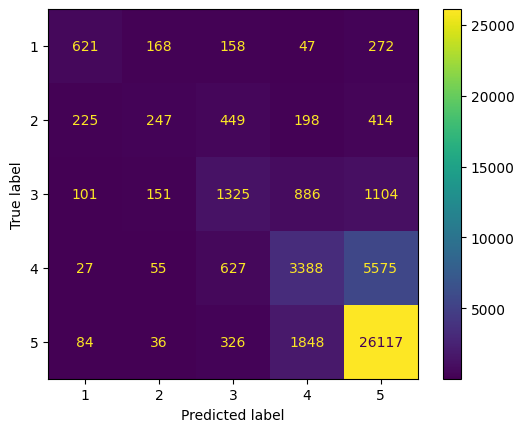

In [50]:
# running all classifiers against X test
lstm_r = lstm.evaluate(X_test1, y_test1)
lstm_y = lstm.predict(X_test1)

ConfusionMatrixDisplay.from_predictions(enc.inverse_transform(y_test1), enc.inverse_transform(lstm_y))
print("F1 score:", f1_score(enc.inverse_transform(y_test1), enc.inverse_transform(lstm_y), average=None))

1390/1390 [==============================] - 10s 7ms/step - loss: 0.7175 - accuracy: 0.7123
F1 score: [0.53686827 0.19011765 0.39335548 0.40526823 0.84340651]


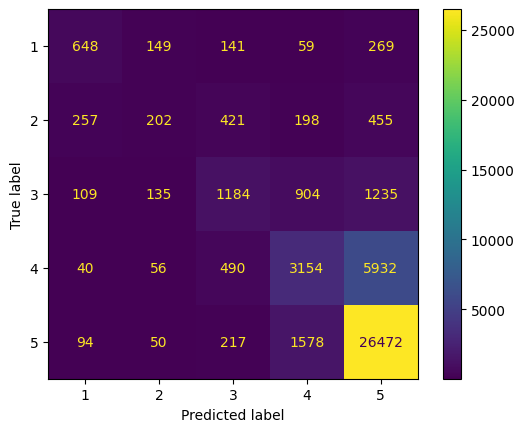

In [51]:
bilstm_r = bilstm.evaluate(X_test1, y_test1)
bilstm_y = bilstm.predict(X_test1)

ConfusionMatrixDisplay.from_predictions(enc.inverse_transform(y_test1), enc.inverse_transform(bilstm_y))
print("F1 score:", f1_score(enc.inverse_transform(y_test1), enc.inverse_transform(bilstm_y), average=None))

1390/1390 [==============================] - 5s 4ms/step - loss: 0.7322 - accuracy: 0.7047
F1 score: [0.53035382 0.18120805 0.37987582 0.43771706 0.84031699]


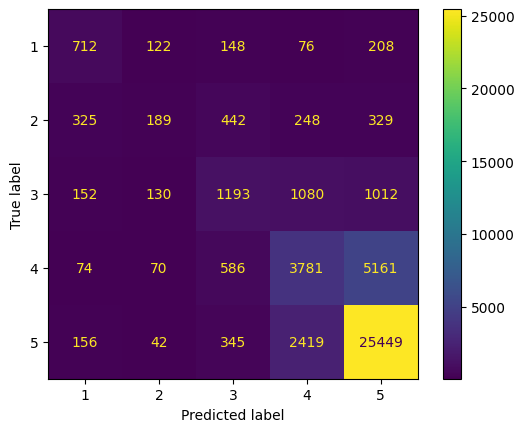

In [53]:
transformer_r = transformer.evaluate(X_test1, y_test1)
transformer_y = transformer.predict(X_test1)

ConfusionMatrixDisplay.from_predictions(enc.inverse_transform(y_test1), enc.inverse_transform(transformer_y))
print("F1 score:", f1_score(enc.inverse_transform(y_test1), enc.inverse_transform(transformer_y), average=None))

1390/1390 [==============================] - 6s 4ms/step - loss: 0.7108 - accuracy: 0.7158
F1 score: [0.51378446 0.2622687  0.39714512 0.42759146 0.84742371]


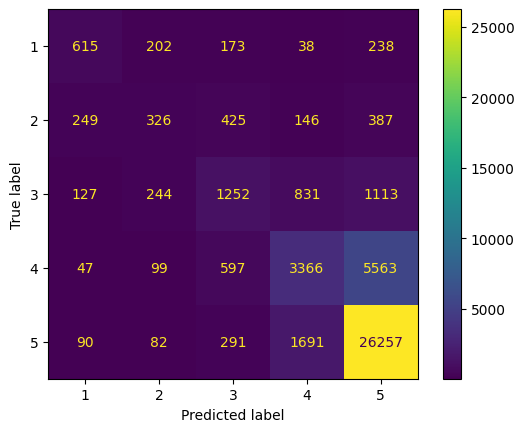

In [54]:
w_lstm_r = w_lstm.evaluate(X_test2, y_test2)
w_lstm_y = w_lstm.predict(X_test2)

ConfusionMatrixDisplay.from_predictions(enc.inverse_transform(y_test2), enc.inverse_transform(w_lstm_y))
print("F1 score:", f1_score(enc.inverse_transform(y_test2), enc.inverse_transform(w_lstm_y), average=None))

1390/1390 [==============================] - 10s 7ms/step - loss: 0.7149 - accuracy: 0.7161
F1 score: [0.51426139 0.29225486 0.3764829  0.44308771 0.84657681]


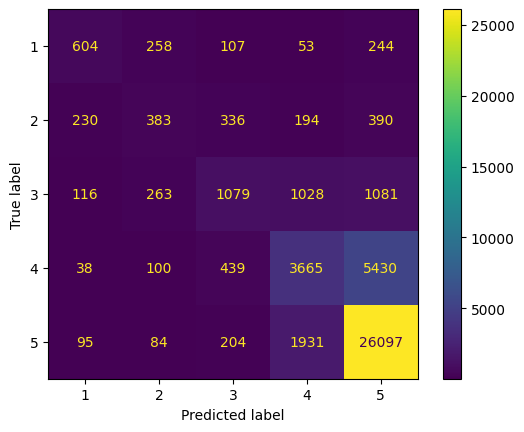

In [55]:
w_bilstm_r = w_bilstm.evaluate(X_test2, y_test2)
w_bilstm_y = w_bilstm.predict(X_test2)

ConfusionMatrixDisplay.from_predictions(enc.inverse_transform(y_test2), enc.inverse_transform(w_bilstm_y))
print("F1 score:", f1_score(enc.inverse_transform(y_test2), enc.inverse_transform(w_bilstm_y), average=None))

1390/1390 [==============================] - 5s 4ms/step - loss: 0.7359 - accuracy: 0.7071
F1 score: [0.51643945 0.1752325  0.31996916 0.38840391 0.83969729]


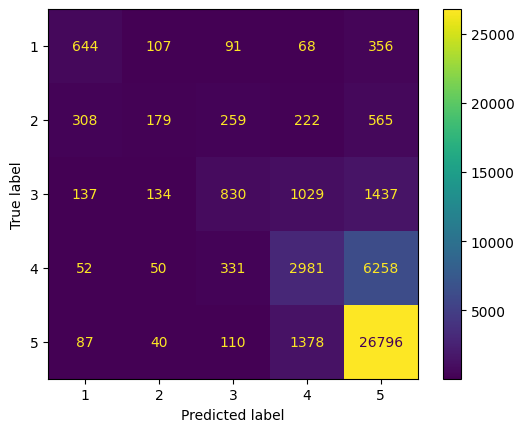

In [57]:
w_transformer_r = w_transformer.evaluate(X_test2, y_test2)
w_transformer_y = w_transformer.predict(X_test2)

ConfusionMatrixDisplay.from_predictions(enc.inverse_transform(y_test2), enc.inverse_transform(w_transformer_y))
print("F1 score:", f1_score(enc.inverse_transform(y_test2), enc.inverse_transform(w_transformer_y), average=None))

#### Accuracy and Loss Table

| Model Description | Accuracy | Loss | F1 1 | F1 2 | F1 3 | F1 4 | F1 5 |
| ----------------- | -------- | ---- | ---- | ---- | ---- | ---- | ---- |
| LSTM | 0.7131 | 0.7182 | 0.53442341 | 0.22557078 | 0.41072536 |0.42247023 | 0.84394035 |
| Bidirectional LSTM | 0.7123 | 0.7175 | 0.53686827 | 0.19011765 | 0.39335548 | 0.40526823 | 0.84340651 |
| Transformer | 0.7047 | 0.7322 | 0.53035382 | 0.18120805 | 0.37987582 | 0.43771706 | 0.84031699 |
| LSTM - Word2Vec Embedding | 0.7158 | 0.7108 | 0.51378446 | 0.2622687  | 0.39714512 | 0.42759146 | 0.84742371|
| Bidirectional LSTM - Word2Vec Embedding | 0.7161 | 0.7149 | 0.51426139 | 0.29225486 | 0.3764829  | 0.44308771 | 0.84657681 |
| Transformer - Word2Vec Embedding | 0.7071 | 0.7359 | 0.51643945 | 0.1752325  | 0.31996916 | 0.38840391 | 0.83969729 |

As the difference between the accuracies of the different models is almost negligible, we will pick the model with the best loss and f1 scores, which is - **Bidirectional LSTM with Word2Vec embeddings**. 
The second best model is the LSTM without Word2Vec embeddings.

From the f1 scores, we can see that all models were only able to classify class 5 well as it is the class with the most training data. Rest of the classes, especially class 2, fell short of the f1 score. This is because of the imbalanced data and presence of two outliers (class 1 and 2). Surprisingly class 1 had approx. 50% f1 score in all models even though it is the class with the least training data.

The main reason of choosing to train models with the pretrained Word2Vec embeddings was that models were converging to local minima really quickly and giving unsatisfactory results. Unfortunately, using Word2Vec did not provide much aid with the results.

For comparison with Bag of Words model, we will use both LSTM and Bidirectional LSTM with Word2Vec embeddings.

## Comparison with Bag of Words

# FastText Classification

In [ ]:
#pip install fasttext

Note: you may need to restart the kernel to use updated packages.


In [1]:
import fasttext

In [4]:
#Change to train if running it from beginning
preprocessed = pd.read_pickle('preproc.pkl')
ftDf = preprocessed[['overall', 'Lemmatized Reviews']].copy()
ftDf.iloc[:, 0] = ftDf.iloc[:, 0].apply(lambda x: '__label__' + str(x))
ftDf.shape

(222243, 2)

In [5]:
# Splitting into test and train
import csv

training = ftDf.sample(frac=0.7)
testing = ftDf.drop(training.index)

training.to_csv('train.txt',
                index=False,
                sep=' ',
                header=None,
                quoting=csv.QUOTE_NONE,
                quotechar="",
                escapechar=" ")

testing.to_csv('test.txt',
               index=False,
               sep=' ',
               header=None,
               quoting=csv.QUOTE_NONE,
               quotechar="",
               escapechar=" ")

In [6]:
ftModel = fasttext.train_supervised(input ='train.txt', autotuneValidationFile = 'test.txt')

In [7]:
ftModel.test('test.txt')

(66673, 0.7073478019588139, 0.7073478019588139)

This represents a precision and recall respectively, making the F1-score 0.7073. This sccore is slightly outperforms shallow learning techniques like Naive Bayes, however, it does not outperform models that model text as a sequence such as LSTM.

# 6. Topic Modelling

In [24]:
# Required imports
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
import math


In [25]:
def plot_top_words(lda, nb_topics, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = plt.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))

In [32]:
preprocessed = pd.read_pickle('preproc.pkl')

For topic modelling, lemmatization is chosen over stemming as it preserves the word. Since stemming can generate words that do not exist, it is difficult to group them into topics.

### Topic Modelling for all reviews

In [33]:
# Builds a dictionary for each word in lemmatized
review_dict = Dictionary(preprocessed['Lemmatized Reviews'])

# Builds corpus - vectors that represent the occurence of each word 
corpus = [review_dict.doc2bow(review) for review in preprocessed['Lemmatized Reviews']]

Here we evaluate the coherence of topics found. Coherence is a measure of semantic similarity between words and is often used to help decide how many topics there are.

In [34]:
# Computes coherence
from tqdm import tqdm

review_coherence = []
for nb_topics in tqdm(range(1,20)):
    lda = LdaModel(corpus, num_topics = nb_topics, id2word = review_dict, passes=10)
    cohm = CoherenceModel(model=lda, corpus=corpus, dictionary=review_dict, coherence='u_mass')
    coh = cohm.get_coherence()
    review_coherence.append(coh)



100%|██████████| 19/19 [7:05:55<00:00, 1345.01s/it]  


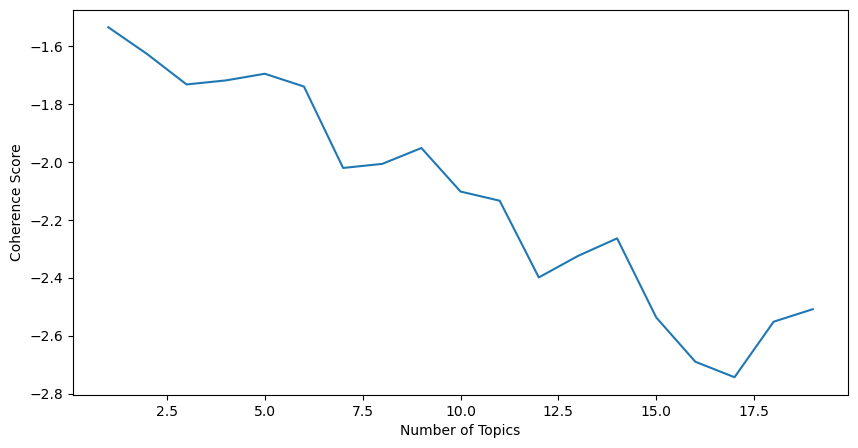

In [35]:
# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,20),review_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

Through the graph, the optimal number of topics should be 5. We use the graph to look for where the average coherence score plateaus, which would be around 3 - 6 topics on our graph.

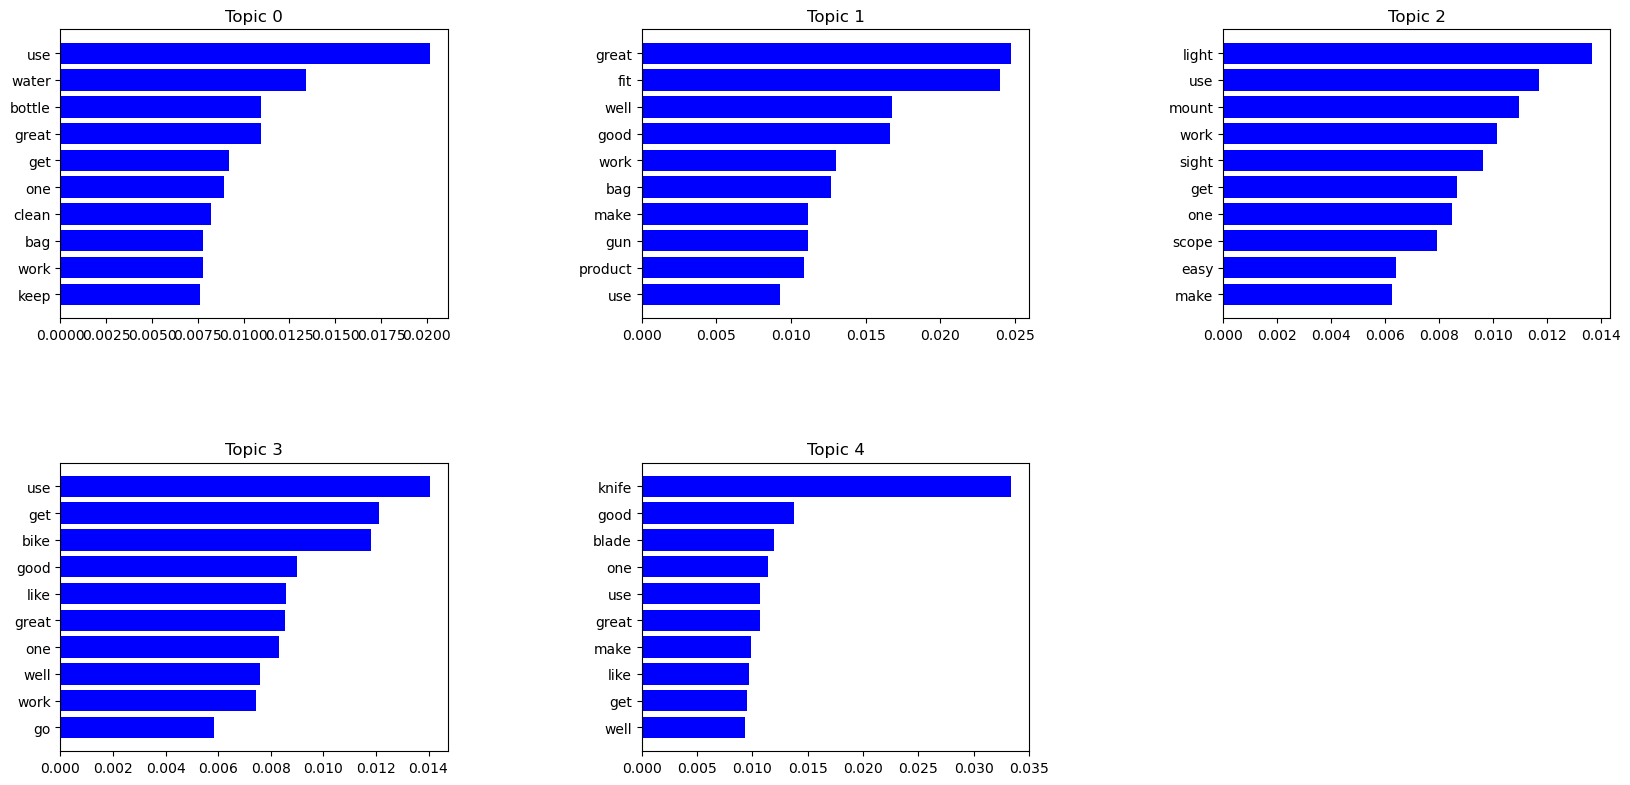

In [36]:

k = 5
review_lda = LdaModel(corpus, num_topics = k, id2word = review_dict, passes=10)
  
plot_top_words(review_lda, 5)

From the results, all topics include words such as "like", "great" and "good" which don't add any meaning to the topics, therefore, we will run LDA again, without these words.

In [37]:
new_stops = ['good', 'great', 'like', 'well']

preprocessed['Adjusted Lemmatized'] = preprocessed['Lemmatized Reviews'].apply(lambda rev : [word for word in rev if word not in new_stops])

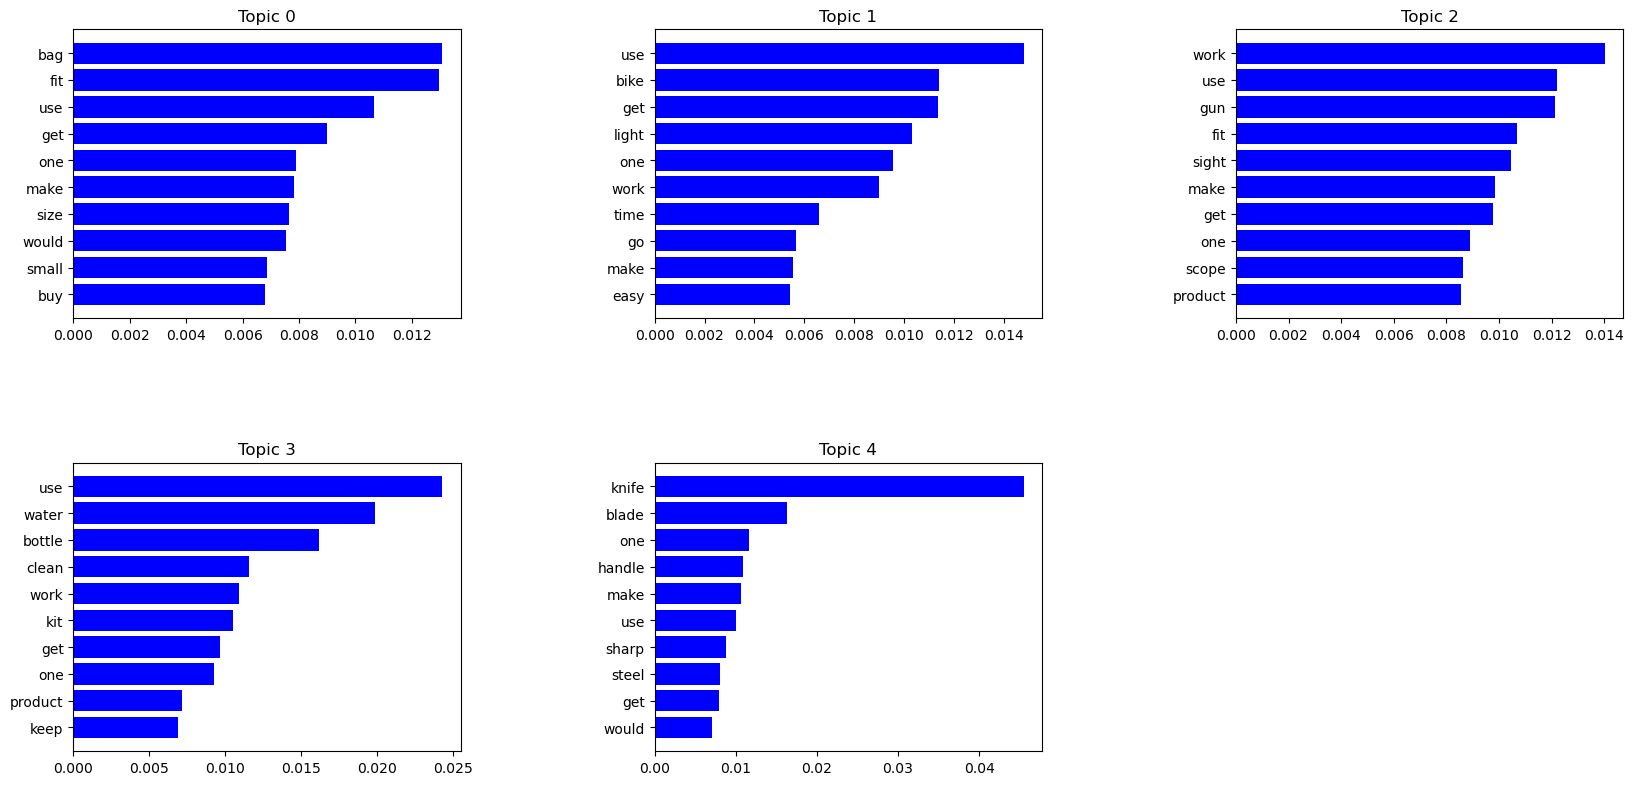

In [38]:
review_dict = Dictionary(preprocessed['Adjusted Lemmatized'])
corpus = [review_dict.doc2bow(review) for review in preprocessed['Adjusted Lemmatized']]

k = 5
reviews_lda = LdaModel(corpus, num_topics = k, id2word = review_dict, passes=10)
  
plot_top_words(reviews_lda, k)

With the results, we can derive the following topics from the overall dataset:
1. Topic 1: Clothing, garment or accessory
2. Topic 2: Bikes 
3. Topic 3: Gun models
4. Topic 4: Water bottles
5. Topic 5: Knives

### Topic Modelling for 1 star Reviews

Here, we will evaluate the topics from 1 star reviews alone.

In [ ]:
lowstardf= preprocessed[preprocessed['overall'] == 1]
lowstardf.head()

(6729, 7)

In [ ]:
# Builds a dictionary for each word in lemmatized
review_dict = Dictionary(lowstardf['Lemmatized Reviews'])

# Builds corpus - vectors that represent the occurence of each word 
corpus = [review_dict.doc2bow(review) for review in lowstardf['Lemmatized Reviews']]

Here, we try to find the optimal number of topics for LDA. Using the same strategy as previously, we evaluate the coherence of various LDA models. 

In [ ]:
# Computes coherence
from tqdm import tqdm

review_coherence = []
for nb_topics in tqdm(range(10,20)):
    lda = LdaModel(corpus, num_topics = nb_topics, id2word = review_dict, passes=10)
    cohm = CoherenceModel(model=lda, corpus=corpus, dictionary=review_dict, coherence='u_mass')
    coh = cohm.get_coherence()
    review_coherence.append(coh)

100%|██████████| 10/10 [07:56<00:00, 47.60s/it]


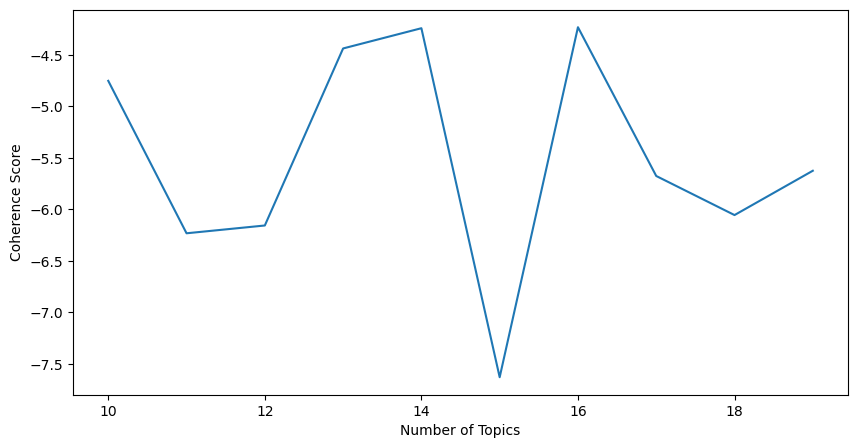

In [ ]:
# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(10,20),review_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

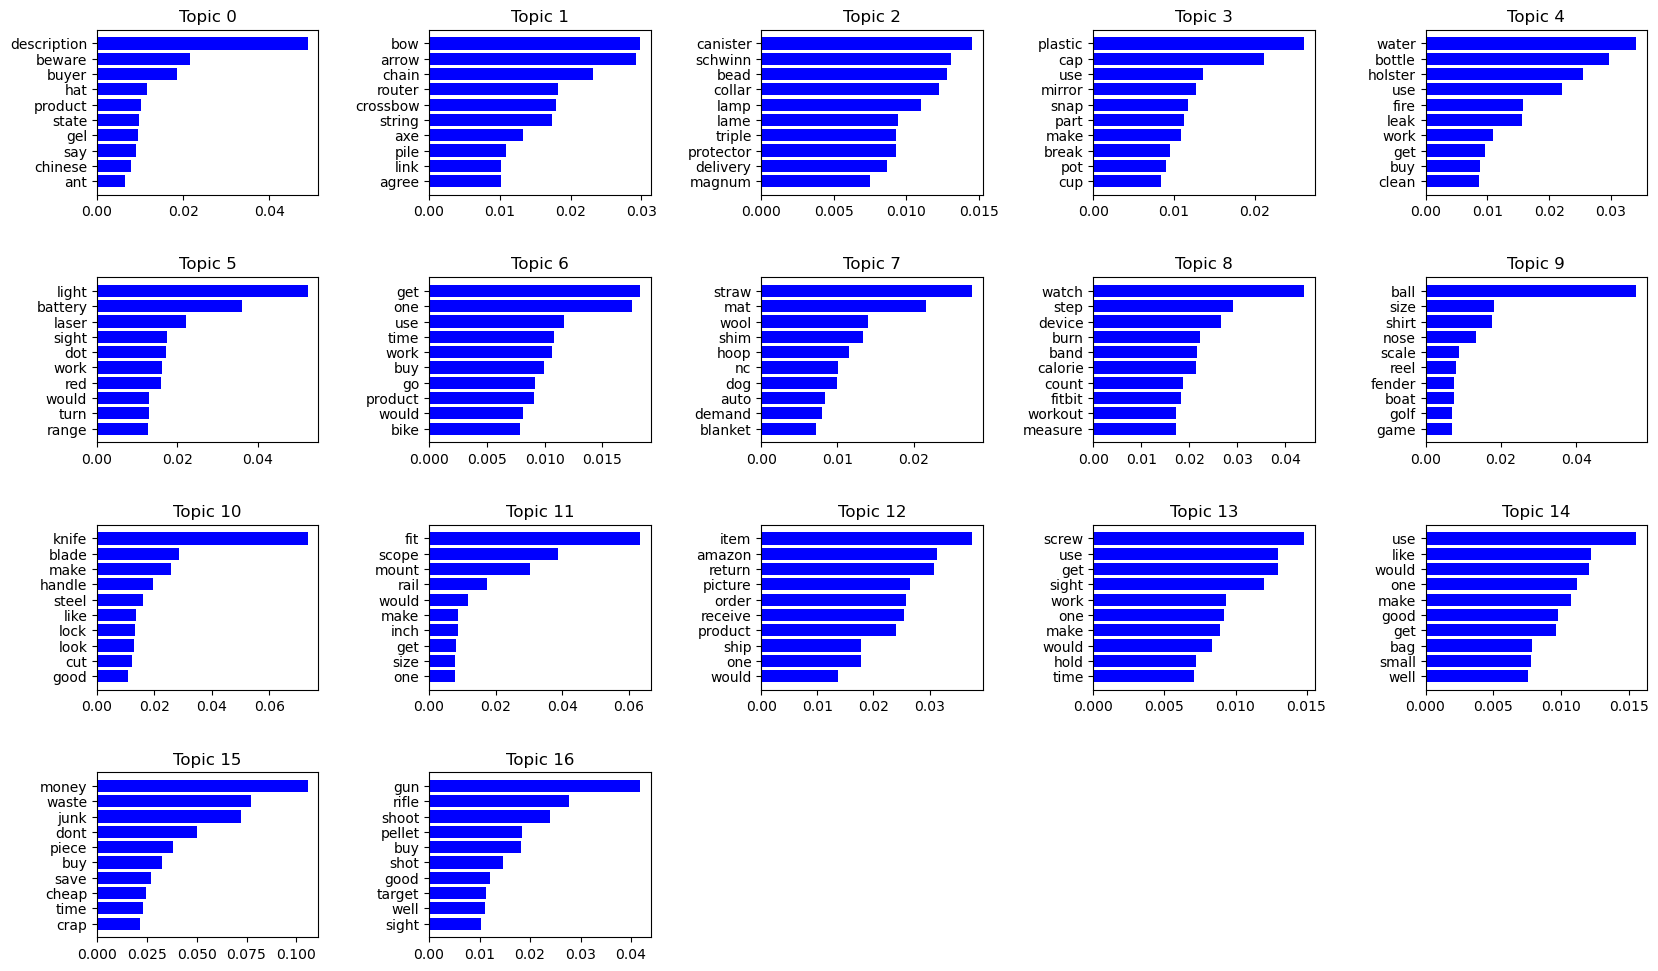

In [ ]:
k = 17
low_lda = LdaModel(corpus, num_topics = k, id2word = review_dict, passes=10)
plot_top_words(low_lda, k)

From the topics shown, a general theme across several topics is that the topic modelled contains the review's "complaint" for the said item in the topic. This is shown with how Topic 0 includes "description", "beware" and Topic 3 includes "break". Topic 15 is also oberved to be a topic containing negative words from reviews.

However, it should be observed that without the added context of knowing this is modelled from 1-star reviews, the topics(with exception of topic 15) are not definitively negative. 

### Topic Modelling for 5 star Reviews


Here, we evaluate the models from 5 star reviews.

In [39]:
highstardf= preprocessed[preprocessed['overall'] == 5]
highstardf.shape

(141169, 8)

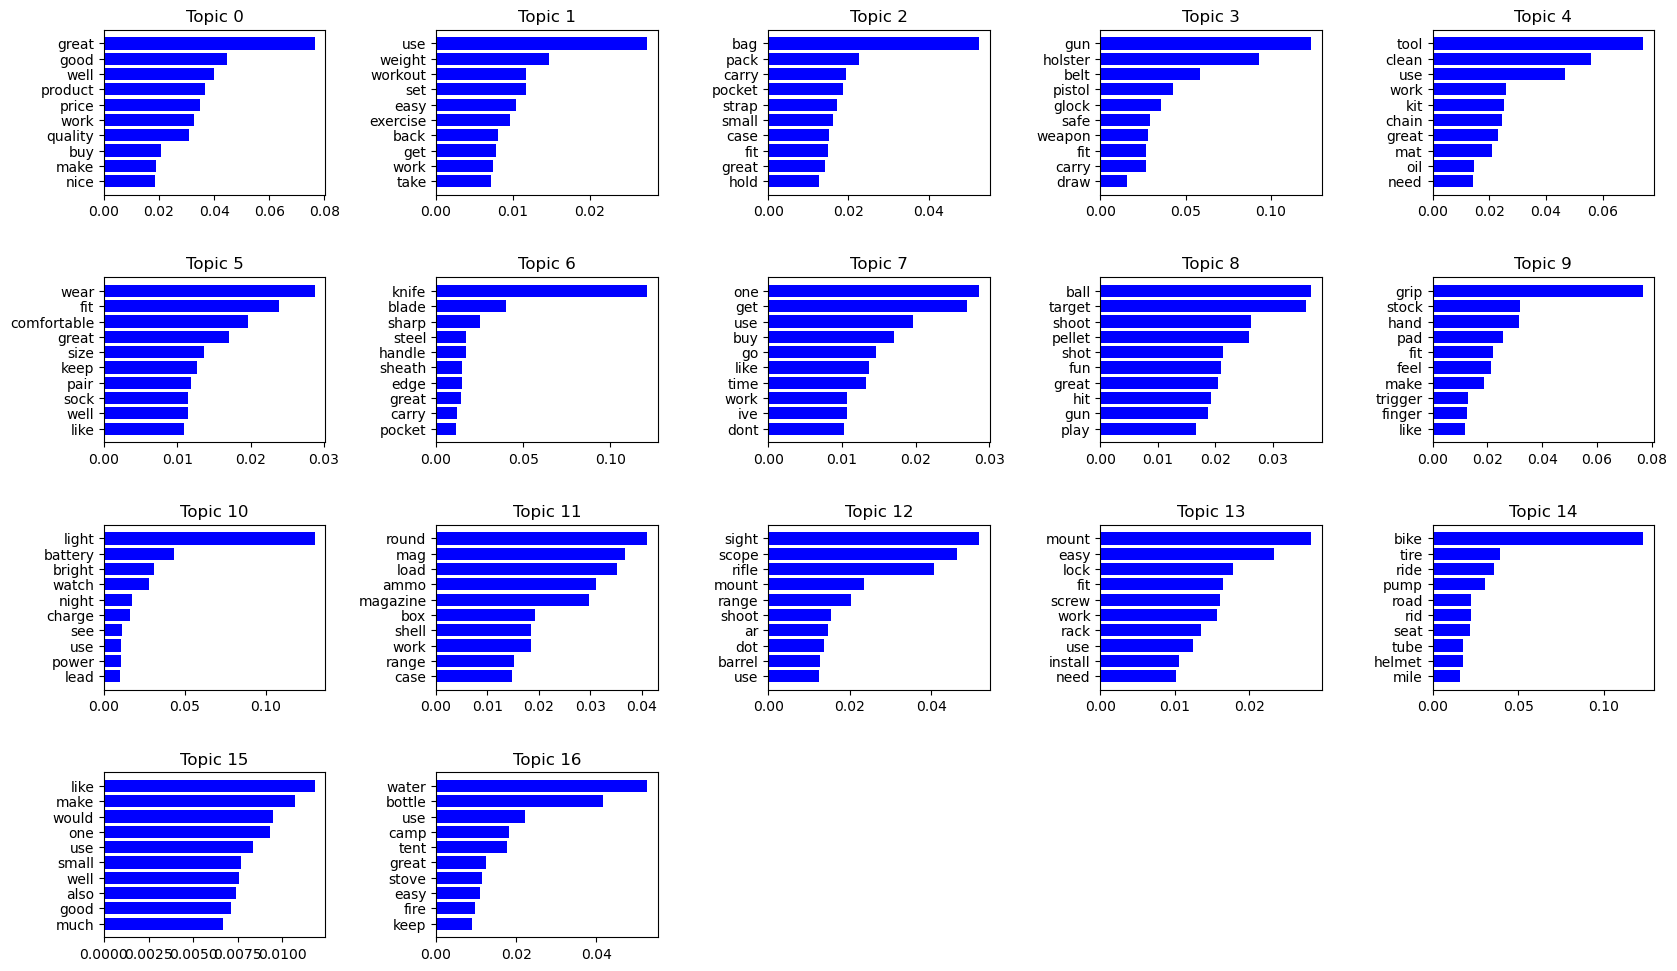

In [40]:
review_dict = Dictionary(highstardf['Lemmatized Reviews'])
corpus = [review_dict.doc2bow(review) for review in highstardf['Lemmatized Reviews']]

#Using the same number of topics as the 1 star reviews
k = 17
high_lda = LdaModel(corpus, num_topics = k, id2word = review_dict, passes=10)
plot_top_words(high_lda, k)

From the topics modelled, the opposite observation is true. The general observation across topics for 5 star reviews is that the topic will contain the positive aspect of the topic's item - for example, in Topic 5, which seems to be a topic about socks, "comfortable" and "great" are present. Similarly, Topic 4, which seems to be about an outdoor tool that uses a chain, contains the words "clean" and "great".

Overall, from the topics modelled, it is more clearly shown that these topics have a positive sentiment.

### Evaluation of Topic Modelling for 1 star and 5 star reviews

As a whole, topic modelling aided in our understanding of the results from classification. Through experimentaton, we had found that the average classification accuracy was around 70%. Topic modelling 1 star reviews showed that there is not enough data on 1 star reviews to be able to accurately model the reviews' topics and negative sentiment. Imbalanced datasets are a common pitfall with machine learning, consequently, LDA as well. 

As there is a lack in 1 star reviews, the topics in 5 and 1 star reviews are very similar, and therefore can also be a reason of why our classification did not exceed 70%. There lacks a clear correlation of topics and words to a specific rating. With exception of words such as "good", "bad" etc, both ratings' reviews would contain largely similar topics and would therefore have similar correlation between the ratings. This makes it difficult for a ML model to clearly distinguish between the features' importance to that rating.